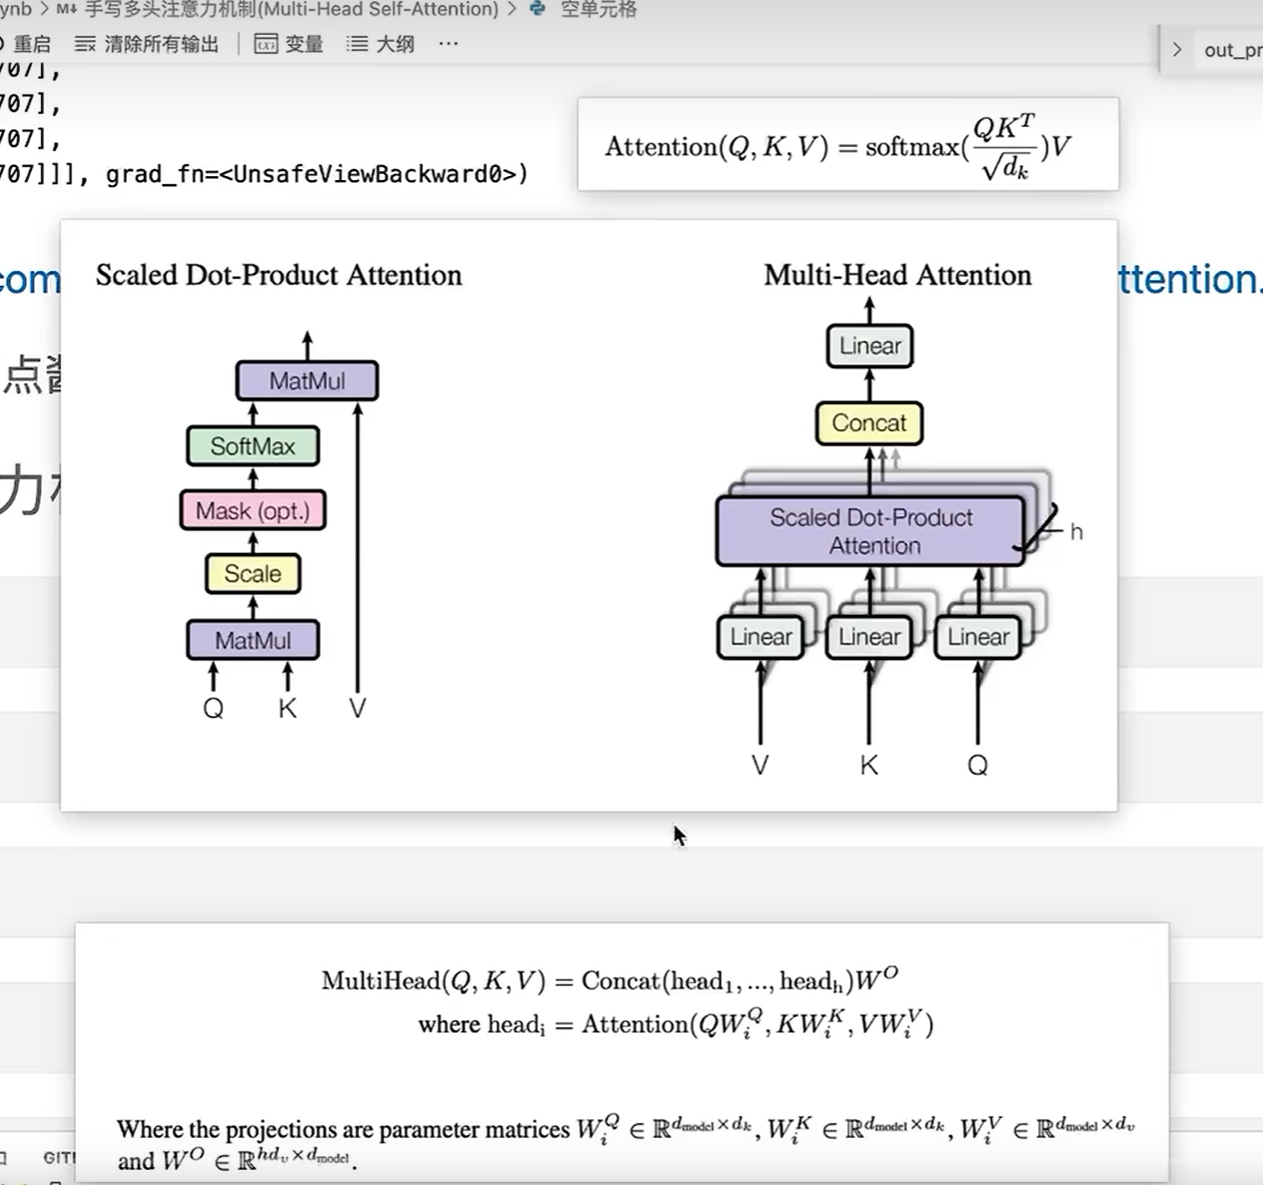

In [10]:
import torch
import math
import torch.nn as nn


class MultiheadSelfAttentionFormal(nn.Module):
    def __init__(self,hidden_dim,head_num, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // head_num # head_dim * head_num == hidden_dim
        self.dropout = nn.Dropout(dropout)
        self.q_proj = nn.Linear(hidden_dim, hidden_dim)
        self.k_proj = nn.Linear(hidden_dim, hidden_dim)
        self.v_proj = nn.Linear(hidden_dim, hidden_dim)
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)
        self.head_num = head_num
    def forward(self, X, mask = None):
        # X:(b, s, h)
        batch, seq_len,_ = X.size()
        Q = self.q_proj(X)
        K = self.k_proj(X)
        V = self.v_proj(X)

        # (b s h) => (b head_num s head_dim)
        # 注意这里不能直接view到特定的维度 因为head_num head_dim都是h产生的 循序渐进
        q_state = Q.view(batch, seq_len, self.head_num, self.head_dim).permute(0,2,1,3)
        k_state = K.view(batch, seq_len, self.head_num, self.head_dim).permute(0,2,1,3)
        v_state = V.view(batch, seq_len, self.head_num, self.head_dim).permute(0,2,1,3)

        # (b head_num s s)
        attention_weight = torch.matmul(
            q_state, k_state.transpose(-1,-2) 
        ) / math.sqrt(self.head_dim)
        if mask is not None:
            attention_weight = attention_weight.masked_fill(
                mask == 0,
                -torch.inf
            )
        print(attention_weight.shape)
        # softmax以后再dropout 因为dropout是变0 这样再softmax就变成1 是错误的
        attention_weight = self.dropout(torch.softmax(attention_weight,-1))
        
        output_mid = torch.matmul(
            attention_weight, v_state
        ) # b headnum s headdim

        output_mid = output_mid.transpose(1, 2).contiguous() # 让存储的内存连续 否则view会报错（reshape怎么都不会报错）
        output_mid = output_mid.view(batch, seq_len, -1)# 变回b s h

        output = self.out_proj(output_mid)
        return output
        
        

In [2]:
X = torch.rand(3,4,2)
X.shape

torch.Size([3, 4, 2])

In [4]:
X.size()

torch.Size([3, 4, 2])

In [5]:
X.shape ==X.size()

True

In [14]:
mask = torch.tensor(
    [
        [0,1],
        [0,0],
        [1,1],
    ]
).unsqueeze(1).unsqueeze(2).expand(3,8,2,2) # mask一开始的大小应该是batch seq
# batch head_num seq seq
# 直接变到3822形状  原先的形状应该是3822各自的约数

X = torch.rand(3,2,128)

net = MultiheadSelfAttentionFormal(128,8)# 128hidden 8头
y = net(X, mask)
y

torch.Size([3, 8, 2, 2])


tensor([[[-2.0163e-01, -3.2828e-01, -2.3487e-01, -1.1194e-01, -3.5518e-01,
           1.7772e-02,  1.6093e-01,  5.3204e-02,  1.2550e-01, -4.0373e-03,
          -2.5437e-01, -1.2655e-01, -4.6825e-03,  2.0318e-01, -1.4159e-01,
          -5.1045e-02,  2.0416e-01, -5.1506e-02, -4.6153e-01, -1.3763e-01,
           3.6094e-01,  2.2937e-01,  1.6870e-01,  2.4425e-01,  3.9054e-01,
           2.8717e-02, -1.1987e-01, -1.6074e-01, -3.2760e-01, -3.2490e-02,
           1.5417e-01, -2.1855e-01, -1.1003e-01,  9.6147e-02,  1.5199e-01,
          -2.5784e-01,  6.6295e-02,  8.2232e-02, -3.0608e-02,  1.3269e-01,
          -6.0534e-02,  2.1388e-03,  3.4878e-02, -8.5117e-02, -1.1291e-01,
           3.2788e-02, -7.7617e-02,  4.7385e-03, -1.7426e-01, -2.8234e-01,
          -1.1446e-01,  7.5369e-02,  9.2028e-03, -2.2203e-01,  7.1296e-02,
          -1.4137e-01,  1.9633e-01,  1.7782e-02,  6.4364e-02,  8.3370e-02,
          -1.9677e-01, -2.1386e-01,  1.1704e-01, -5.9974e-02, -1.4836e-01,
          -3.8177e-02,  5

In [15]:
y.shape

torch.Size([3, 2, 128])

In [16]:
t = torch.tensor([[2, 1, 3], [4, 5, 9]])
t2 = t.transpose(0, 1)
t3 = t2.contiguous()
t2,t3

(tensor([[2, 4],
         [1, 5],
         [3, 9]]),
 tensor([[2, 4],
         [1, 5],
         [3, 9]]))

In [17]:
t2 == t3

tensor([[True, True],
        [True, True],
        [True, True]])

In [21]:
t2.view(-1)

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [20]:
t3.view(-1)

tensor([2, 4, 1, 5, 3, 9])

In [22]:
mask.shape

torch.Size([3, 8, 2, 2])